In [1]:
import cartopy
import numpy as np
import xarray as xa
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import cm, colors
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm import tqdm
import matplotlib.ticker as mticker

In [2]:
CESM_hist_range = np.load('Metrics/CESM_hist_range.npy')
CESM_rcp_range = np.load('Metrics/CESM_rcp_range.npy')
print(CESM_rcp_range.shape)
CESM_range_change = -CESM_hist_range + CESM_rcp_range
EC_hist_range = np.load('Metrics/EC_hist_range.npy')
EC_rcp_range = np.load('Metrics/EC_rcp_range.npy')
EC_range_change = -EC_hist_range + EC_rcp_range
GFDL_hist_range = np.load('Metrics/GFDL_hist_range.npy')
GFDL_rcp_range = np.load('Metrics/GFDL_rcp_range.npy')
GFDL_range_change = -GFDL_hist_range + GFDL_rcp_range
CNRM_hist_range = np.load('Metrics/CNRM_hist_range.npy')
CNRM_rcp_range = np.load('Metrics/CNRM_rcp_range.npy')
CNRM_range_change = -CNRM_hist_range + CNRM_rcp_range
HadGEM_hist_range = np.load('Metrics/HadGEM_hist_range.npy')
HadGEM_rcp_range = np.load('Metrics/HadGEM_rcp_range.npy')
HadGEM_range_change = -HadGEM_hist_range + HadGEM_rcp_range
MIROC_hist_range = np.load('Metrics/MIROC_hist_range.npy')
MIROC_rcp_range = np.load('Metrics/MIROC_rcp_range.npy')
MIROC_range_change = -MIROC_hist_range + MIROC_rcp_range

(112, 72)


In [3]:
def add_latlon(ax, left, bottom, right, top):
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = bottom
    gl.right_labels = right
    gl.top_labels = top
    gl.left_labels = left
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator([36, 37, 38, 39, 40, 41])
    gl.xlocator = mticker.FixedLocator([-105, -106, -107, -108])
def plot_snow(ax, snow, norm, levels=None):
    if levels is None:
        ax.contourf(longitude, latitude, snow, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=70)
    else:
        ax.contourf(longitude, latitude, snow, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm', levels=levels)
    ax.add_feature(cartopy.feature.STATES, alpha=0.9)

# MaxSWE

In [4]:
def build_xarray(array, lat, lon):
    data = xa.DataArray(array, dims=['latitude', 'longitude'], coords={'latitude': lat, 'longitude': lon})
    return data
def upsample(nsidc, snow):
    snow_xa = build_xarray(snow, dah.lat.data.reshape(-1), dah.lon.data.reshape(-1))
    nsidc_xa = build_xarray(nsidc, nsidc_lat, nsidc_lon)
    # up_nsidc_xa = nsidc_xa.interp_like(snow_xa, 'nearest')
    up_nsidc_xa = np.zeros_like(snow)
    for i, lat in enumerate(dah.lat.data):
        for j, lon in enumerate(dah.lon.data):
            up_nsidc_xa[i, j] = nsidc_xa.sel(longitude=lon, method='nearest').sel(latitude=lat, method='nearest')
    # print(up_nsidc_xa.shape)
    up_nsidc_xa = build_xarray(up_nsidc_xa, dah.lat.data.reshape(-1), dah.lon.data.reshape(-1))
    return up_nsidc_xa
# nsidc = xa.open_dataarray("../co_prediction/SWES_NSIDC_all.nc")
nsidc = xa.open_dataarray('../NSIDC/SWES_NSIDC_hist.nc')
nsidc = nsidc.reindex(lat=nsidc.lat[::-1])
nsidc = nsidc.transpose("lat", "lon", "time")
print(nsidc.shape)
print(nsidc.time)
nsidc_lon = nsidc.lon.data
nsidc_lat = nsidc.lat.data

(167, 107, 6574)
<xarray.DataArray 'time' (time: 6574)>
array(['1981-10-01T00:00:00.000000000', '1981-10-02T00:00:00.000000000',
       '1981-10-03T00:00:00.000000000', ..., '1999-09-28T00:00:00.000000000',
       '1999-09-29T00:00:00.000000000', '1999-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-10-01 1981-10-02 ... 1999-09-30
Attributes:
    long_name:  time


In [5]:
elevation = xa.open_dataset("topo_file_LOCA.nc")
dah = elevation.dah
trasp = elevation.trasp
latitude = elevation.latitude
longitude = elevation.longitude
elevation = elevation.elevation_prism

max_nsidc = nsidc.max(dim='time')
print(max_nsidc.shape)
MIROC_hist_peak = np.load('Metrics/MIROC_hist_peak.npy')
up_nsidc_max = upsample(max_nsidc, MIROC_hist_peak)
def calculate_model(model):
    hist_peak = np.load('Metrics/'+model+'_hist_peak.npy')
    rcp_peak = np.load('Metrics/'+model+'_rcp_peak.npy')
    hist_peak_SWE = hist_peak*up_nsidc_max
    rcp_peak_SWE = rcp_peak*up_nsidc_max
    return hist_peak_SWE, rcp_peak_SWE

(167, 107)


In [6]:
HadGEM_hist_peak_SWE, HadGEM_rcp_peak_SWE = calculate_model('HadGEM')
EC_hist_peak_SWE, EC_rcp_peak_SWE = calculate_model('EC')
MIROC_hist_peak_SWE, MIROC_rcp_peak_SWE = calculate_model('MIROC')
CESM_hist_peak_SWE, CESM_rcp_peak_SWE = calculate_model('CESM')
CNRM_hist_peak_SWE, CNRM_rcp_peak_SWE = calculate_model('CNRM')
GFDL_hist_peak_SWE, GFDL_rcp_peak_SWE = calculate_model('GFDL')

In [7]:
MIROC_peak_SWE_change = -MIROC_hist_peak_SWE + MIROC_rcp_peak_SWE
HadGEM_peak_SWE_change = -HadGEM_hist_peak_SWE + HadGEM_rcp_peak_SWE
GFDL_peak_SWE_change = -GFDL_hist_peak_SWE + GFDL_rcp_peak_SWE
EC_peak_SWE_change = -EC_hist_peak_SWE + EC_rcp_peak_SWE
CNRM_peak_SWE_change = -CNRM_hist_peak_SWE + CNRM_rcp_peak_SWE
CESM_peak_SWE_change = -CESM_hist_peak_SWE + CESM_rcp_peak_SWE

In [8]:
CESM_hist_acc = np.load('Metrics/CESM_hist_acc.npy')
CESM_rcp_acc = np.load('Metrics/CESM_rcp_acc.npy')
print(CESM_rcp_acc.shape)
CESM_acc_change = -CESM_hist_acc + CESM_rcp_acc
EC_hist_acc = np.load('Metrics/EC_hist_acc.npy')
EC_rcp_acc = np.load('Metrics/EC_rcp_acc.npy')
EC_acc_change = -EC_hist_acc + EC_rcp_acc
GFDL_hist_acc = np.load('Metrics/GFDL_hist_acc.npy')
GFDL_rcp_acc = np.load('Metrics/GFDL_rcp_acc.npy')
GFDL_acc_change = -GFDL_hist_acc + GFDL_rcp_acc
CNRM_hist_acc = np.load('Metrics/CNRM_hist_acc.npy')
CNRM_rcp_acc = np.load('Metrics/CNRM_rcp_acc.npy')
CNRM_acc_change = -CNRM_hist_acc + CNRM_rcp_acc
HadGEM_hist_acc = np.load('Metrics/HadGEM_hist_acc.npy')
HadGEM_rcp_acc = np.load('Metrics/HadGEM_rcp_acc.npy')
HadGEM_acc_change = -HadGEM_hist_acc + HadGEM_rcp_acc
MIROC_hist_acc = np.load('Metrics/MIROC_hist_acc.npy')
MIROC_rcp_acc = np.load('Metrics/MIROC_rcp_acc.npy')
MIROC_acc_change = -MIROC_hist_acc + MIROC_rcp_acc

(112, 72)


In [9]:
CESM_hist_melt = np.load('Metrics/CESM_hist_melt.npy')
CESM_rcp_melt = np.load('Metrics/CESM_rcp_melt.npy')
print(CESM_rcp_melt.shape)
CESM_melt_change = -CESM_hist_melt + CESM_rcp_melt
EC_hist_melt = np.load('Metrics/EC_hist_melt.npy')
EC_rcp_melt = np.load('Metrics/EC_rcp_melt.npy')
EC_melt_change = -EC_hist_melt + EC_rcp_melt
GFDL_hist_melt = np.load('Metrics/GFDL_hist_melt.npy')
GFDL_rcp_melt = np.load('Metrics/GFDL_rcp_melt.npy')
GFDL_melt_change = -GFDL_hist_melt + GFDL_rcp_melt
CNRM_hist_melt = np.load('Metrics/CNRM_hist_melt.npy')
CNRM_rcp_melt = np.load('Metrics/CNRM_rcp_melt.npy')
CNRM_melt_change = -CNRM_hist_melt + CNRM_rcp_melt
HadGEM_hist_melt = np.load('Metrics/HadGEM_hist_melt.npy')
HadGEM_rcp_melt = np.load('Metrics/HadGEM_rcp_melt.npy')
HadGEM_melt_change = -HadGEM_hist_melt + HadGEM_rcp_melt
MIROC_hist_melt = np.load('Metrics/MIROC_hist_melt.npy')
MIROC_rcp_melt = np.load('Metrics/MIROC_rcp_melt.npy')
MIROC_melt_change = -MIROC_hist_melt + MIROC_rcp_melt

(112, 72)


In [10]:
CESM_hist_date = np.load('Metrics/CESM_date_hist.npy')
EC_hist_date = np.load('Metrics/EC_date_hist.npy')
GFDL_hist_date = np.load('Metrics/GFDL_date_hist.npy')
CNRM_hist_date = np.load('Metrics/CNRM_date_hist.npy')
HadGEM_hist_date = np.load('Metrics/HadGEM_date_hist.npy')
MIROC_hist_date = np.load('Metrics/MIROC_date_hist.npy')
CESM_rcp_date = np.load('Metrics/CESM_date_rcp.npy')
EC_rcp_date = np.load('Metrics/EC_date_rcp.npy')
GFDL_rcp_date = np.load('Metrics/GFDL_date_rcp.npy')
CNRM_rcp_date = np.load('Metrics/CNRM_date_rcp.npy')
HadGEM_rcp_date = np.load('Metrics/HadGEM_date_rcp.npy')
MIROC_rcp_date = np.load('Metrics/MIROC_date_rcp.npy')

MIROC_date_change = -MIROC_hist_date + MIROC_rcp_date
HadGEM_date_change = -HadGEM_hist_date + HadGEM_rcp_date
EC_date_change = -EC_hist_date + EC_rcp_date
GFDL_date_change = -GFDL_hist_date + GFDL_rcp_date
CESM_date_change = -CESM_hist_date + CESM_rcp_date
CNRM_date_change = -CNRM_hist_date + CNRM_rcp_date

In [11]:
print(np.min([GFDL_date_change, EC_date_change, HadGEM_date_change, CNRM_date_change, CESM_date_change, MIROC_date_change]))
print(np.max([GFDL_date_change, EC_date_change, HadGEM_date_change, CNRM_date_change, CESM_date_change, MIROC_date_change]))
date_norm = colors.TwoSlopeNorm(vcenter=0, vmax=75, vmin=-60)

-74.33333333333334
56.277777777777786


In [12]:
print(np.min([GFDL_melt_change, EC_melt_change, HadGEM_melt_change, CNRM_melt_change, CESM_melt_change, MIROC_melt_change]))
print(np.max([GFDL_melt_change, EC_melt_change, HadGEM_melt_change, CNRM_melt_change, CESM_melt_change, MIROC_melt_change]))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmax=110, vmin=-50)

-107.33333333333331
48.72222222222223


In [13]:
print(np.min([GFDL_acc_change, EC_acc_change, HadGEM_acc_change, CNRM_acc_change, CESM_acc_change, MIROC_acc_change]))
print(np.max([GFDL_acc_change, EC_acc_change, HadGEM_acc_change, CNRM_acc_change, CESM_acc_change, MIROC_acc_change]))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmax=37, vmin=-84)

-36.8888888888889
83.33333333333333


In [14]:
print(np.nanmin([GFDL_peak_SWE_change, EC_peak_SWE_change, HadGEM_peak_SWE_change, CNRM_peak_SWE_change, CESM_peak_SWE_change, MIROC_peak_SWE_change]))
print(np.nanmax([GFDL_peak_SWE_change, EC_peak_SWE_change, HadGEM_peak_SWE_change, CNRM_peak_SWE_change, CESM_peak_SWE_change, MIROC_peak_SWE_change]))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmax=270, vmin=-225)
print(np.nanmin(CESM_peak_SWE_change.data), ' ', np.nanmax(CESM_peak_SWE_change.data))
print(np.nanmin(GFDL_peak_SWE_change.data), ' ', np.nanmax(GFDL_peak_SWE_change.data))
print(np.nanmin(EC_peak_SWE_change.data), ' ', np.nanmax(EC_peak_SWE_change.data))
print(np.nanmin(HadGEM_peak_SWE_change.data), ' ', np.nanmax(HadGEM_peak_SWE_change.data))
print(np.nanmin(CNRM_peak_SWE_change.data), ' ', np.nanmax(CNRM_peak_SWE_change.data))
print(np.nanmin(MIROC_peak_SWE_change.data), ' ', np.nanmax(MIROC_peak_SWE_change.data))

-264.0617874916229
221.39997050911165
-209.73467302446556   177.95836655894914
-95.95293676368895   115.86980866889166
-127.3002658293479   221.39997050911165
-153.5408466008803   150.9231031638053
-133.8982106935233   201.53308397051353
-264.0617874916229   4.771006643772132


In [15]:
print(np.min([GFDL_range_change, EC_range_change, HadGEM_range_change, CNRM_range_change, CESM_range_change, MIROC_range_change]))
print(np.max([GFDL_range_change, EC_range_change, HadGEM_range_change, CNRM_range_change, CESM_range_change, MIROC_range_change]))
range_norm = colors.TwoSlopeNorm(vcenter=0, vmax=120, vmin=-18)

-119.72222222222221
16.388888888888886


In [32]:
def plot_snow(fig, ax, snow, levels, norm, use_con=False):
    ax.add_feature(cartopy.feature.STATES, alpha=0.9)
    con=ax.contourf(dah.lon.data, dah.lat.data, snow, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm", levels=levels)
    divider = make_axes_locatable(ax)
    cax1 = divider.new_vertical(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=True)
    fig.add_axes(cax1)
    if use_con:
        fig.colorbar(
            con,
            cax=cax1,
            orientation="horizontal",
            ticks=np.linspace(-100, 0, 5)
        )
    else:
        fig.colorbar(
            cm.ScalarMappable(norm=norm, cmap="coolwarm"),
            cax=cax1,
            orientation="horizontal",
            # ticks=np.linspace(0, 100, 5)
        )

# CESM

SSL -105.94444444444443   -2.0
SAD -25.555555555555557   58.611111111111114
CMD -79.72222222222223   10.5
SPD -63.05555555555556   24.72222222222223
PeakSWE -209.73467302446556   177.95836655894914


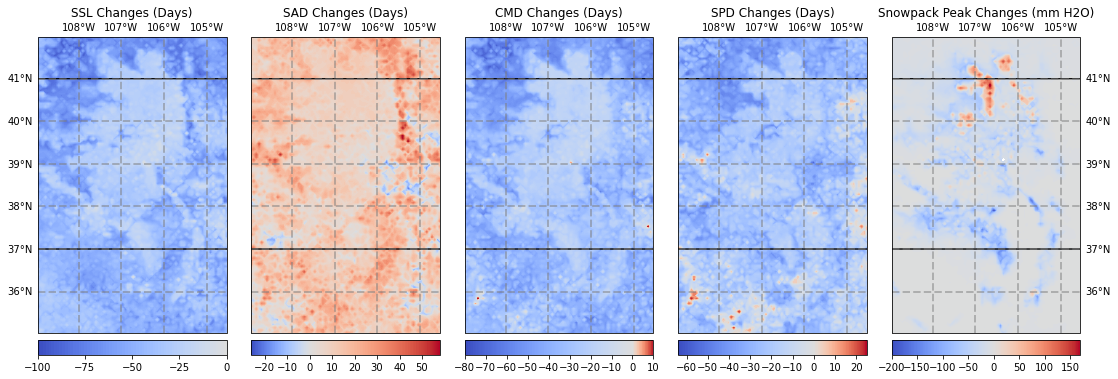

In [34]:
fig = plt.figure(figsize=(15, 7))
# SSL
print('SSL', np.nanmin(CESM_range_change.data), ' ', np.nanmax(CESM_range_change.data))
range_norm = colors.Normalize(vmin=-100, vmax=100)
levels = np.linspace(-100, 0, 70)
ax = fig.add_subplot(151, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CESM_range_change, levels, range_norm, use_con=True)
ax.set_title('SSL Changes (Days)', fontsize=12)
add_latlon(ax, left=True, bottom=False, right=False, top=True)
# SAD
print('SAD', np.nanmin(CESM_acc_change.data), ' ', np.nanmax(CESM_acc_change.data))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-26, vmax=58)
ax = fig.add_subplot(152, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CESM_acc_change, norm=acc_norm, use_con=False, levels=70)
ax.set_title('SAD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# CMD
print('CMD', np.nanmin(CESM_melt_change.data), ' ', np.nanmax(CESM_melt_change.data))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-80, vmax=10)
levels1 = np.linspace(-80, 0, 70)
levels2 = np.linspace(0, 11, 5)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(153, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CESM_melt_change, levels, melt_norm, use_con=False)
ax.set_title('CMD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# SPD
print('SPD', np.nanmin(CESM_date_change.data), ' ', np.nanmax(CESM_date_change.data))
ax = fig.add_subplot(154, projection=cartopy.crs.PlateCarree())
date_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-64, vmax=25)
levels1 = np.linspace(-64, 0, 70)
levels2 = np.linspace(0, 25, 10)
levels = np.concatenate((levels1[:-1], levels2))
plot_snow(fig, ax, CESM_date_change, levels, date_norm, use_con=False)
ax.set_title('SPD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# Peak SWE
print('PeakSWE', np.nanmin(CESM_peak_SWE_change.data), ' ', np.nanmax(CESM_peak_SWE_change.data))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-200, vmax=170)
levels1 = np.linspace(-210, 0, 70)
levels2 = np.linspace(0, 180, 40)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(155, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CESM_peak_SWE_change, levels, peak_SWE_norm, use_con=False)
ax.set_title('Snowpack Peak Changes (mm H2O)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

# MIROC

SSL -93.00000000000001   -9.555555555555557
SAD -7.6111111111111   64.83333333333334
CMD -60.77777777777777   48.72222222222223
SPD -45.222222222222214   56.277777777777786
PeakSWE -264.0617874916229   4.771006643772132


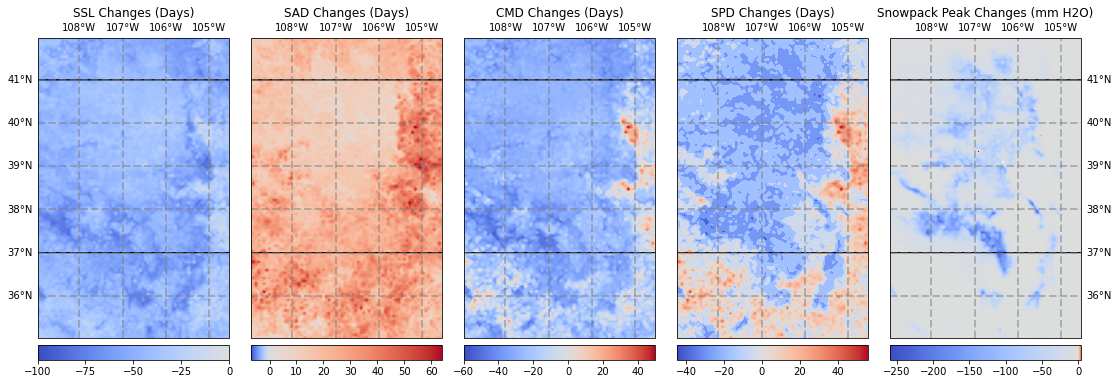

In [38]:
fig = plt.figure(figsize=(15, 7))
# SSL
print('SSL', np.nanmin(MIROC_range_change.data), ' ', np.nanmax(MIROC_range_change.data))
range_norm = colors.Normalize(vmin=-100, vmax=100)
levels = np.linspace(-100, 0, 100)
ax = fig.add_subplot(151, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, MIROC_range_change, levels, range_norm, use_con=True)
ax.set_title('SSL Changes (Days)', fontsize=12)
add_latlon(ax, left=True, bottom=False, right=False, top=True)
# SAD
print('SAD', np.nanmin(MIROC_acc_change.data), ' ', np.nanmax(MIROC_acc_change.data))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-7, vmax=64)
levels1 = np.linspace(-8, 0, 4)
levels2 = np.linspace(0, 65, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(152, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, MIROC_acc_change, levels=levels, norm=acc_norm, use_con=False)
ax.set_title('SAD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# CMD
print('CMD', np.nanmin(MIROC_melt_change.data), ' ', np.nanmax(MIROC_melt_change.data))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-60, vmax=50)
levels1 = np.linspace(-61, 0, 50)
levels2 = np.linspace(0, 49, 20)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(153, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, MIROC_melt_change, levels=levels, norm=melt_norm, use_con=False)
ax.set_title('CMD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# SPD
print('SPD', np.nanmin(MIROC_date_change.data), ' ', np.nanmax(MIROC_date_change.data))
ax = fig.add_subplot(154, projection=cartopy.crs.PlateCarree())
date_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-45, vmax=56)
levels1 = np.linspace(-46, 0, 5)
levels2 = np.linspace(0, 56, 70)
levels = np.concatenate((levels1[:-1], levels2))
plot_snow(fig, ax, MIROC_date_change, levels=levels, norm=date_norm, use_con=False)
ax.set_title('SPD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# Peak SWE
print('PeakSWE', np.nanmin(MIROC_peak_SWE_change.data), ' ', np.nanmax(MIROC_peak_SWE_change.data))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-260, vmax=4)
levels1 = np.linspace(-265, 0, 70)
levels2 = np.linspace(0, 5, 5)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(155, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, MIROC_peak_SWE_change, levels=levels, norm=peak_SWE_norm, use_con=False)
ax.set_title('Snowpack Peak Changes (mm H2O)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

# HadGEM

SSL -119.72222222222221   11.5
SAD -21.0   83.33333333333333
CMD -107.33333333333331   37.94444444444443
SPD -74.33333333333334   53.94444444444446
PeakSWE -153.5408466008803   150.9231031638053


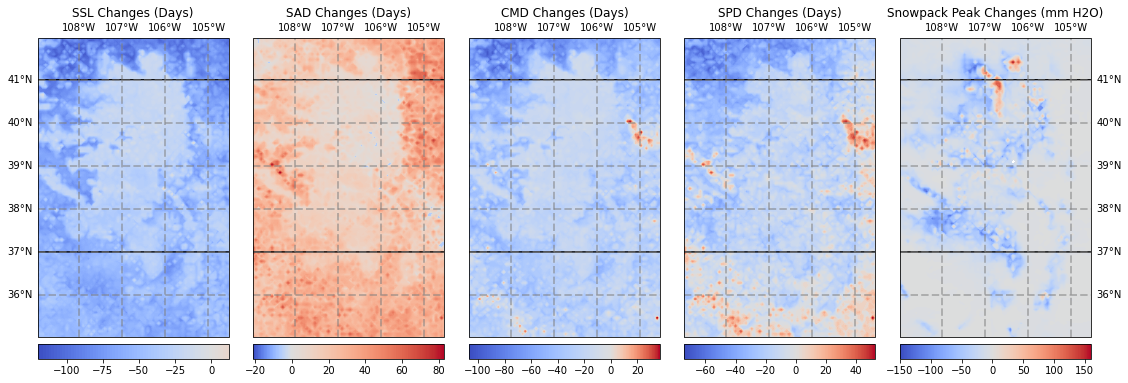

In [42]:
fig = plt.figure(figsize=(15, 7))
# SSL
print('SSL', np.nanmin(HadGEM_range_change.data), ' ', np.nanmax(HadGEM_range_change.data))
range_norm = colors.Normalize(vmin=-120, vmax=120)
levels = np.linspace(-120, 12, 70)
ax = fig.add_subplot(151, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, HadGEM_range_change, levels, range_norm, use_con=True)
ax.set_title('SSL Changes (Days)', fontsize=12)
add_latlon(ax, left=True, bottom=False, right=False, top=True)
# SAD
print('SAD', np.nanmin(HadGEM_acc_change.data), ' ', np.nanmax(HadGEM_acc_change.data))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-21, vmax=83)
levels1 = np.linspace(-22, 0, 3)
levels2 = np.linspace(0, 84, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(152, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, HadGEM_acc_change, levels=levels, norm=acc_norm, use_con=False)
ax.set_title('SAD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# CMD
print('CMD', np.nanmin(HadGEM_melt_change.data), ' ', np.nanmax(HadGEM_melt_change.data))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-107, vmax=37)
levels1 = np.linspace(-108, 0, 60)
levels2 = np.linspace(0, 38, 20)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(153, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, HadGEM_melt_change, levels=levels, norm=melt_norm, use_con=False)
ax.set_title('CMD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# SPD
print('SPD', np.nanmin(HadGEM_date_change.data), ' ', np.nanmax(HadGEM_date_change.data))
ax = fig.add_subplot(154, projection=cartopy.crs.PlateCarree())
date_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-74, vmax=53)
levels1 = np.linspace(-74, 0, 55)
levels2 = np.linspace(0, 55, 20)
levels = np.concatenate((levels1[:-1], levels2))
plot_snow(fig, ax, HadGEM_date_change, levels=levels, norm=date_norm, use_con=False)
ax.set_title('SPD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# Peak SWE
print('PeakSWE', np.nanmin(HadGEM_peak_SWE_change.data), ' ', np.nanmax(HadGEM_peak_SWE_change.data))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-150, vmax=160)
levels1 = np.linspace(-154, 0, 70)
levels2 = np.linspace(0, 151, 30)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(155, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, HadGEM_peak_SWE_change, levels=levels, norm=peak_SWE_norm, use_con=False)
ax.set_title('Snowpack Peak Changes (mm H2O)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

# EC

SSL -83.38888888888889   10.666666666666657
SAD -25.444444444444443   59.500000000000014
CMD -68.33333333333331   35.55555555555557
SPD -53.94444444444444   48.83333333333334
PeakSWE -127.3002658293479   221.39997050911165


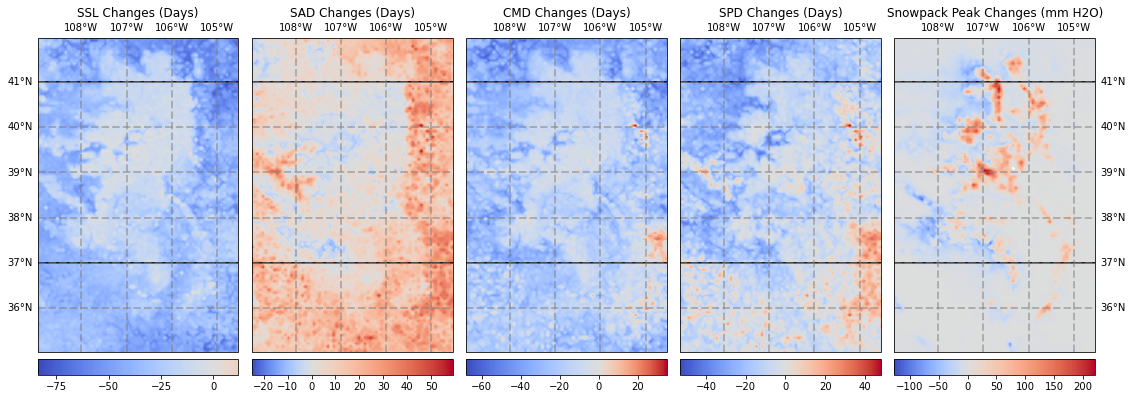

In [50]:
fig = plt.figure(figsize=(15, 7))
# SSL
print('SSL', np.nanmin(EC_range_change.data), ' ', np.nanmax(EC_range_change.data))
range_norm = colors.Normalize(vmin=-83, vmax=83)
ax = fig.add_subplot(151, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, EC_range_change, levels=70, norm=range_norm, use_con=True)
ax.set_title('SSL Changes (Days)', fontsize=12)
add_latlon(ax, left=True, bottom=False, right=False, top=True)
# SAD
print('SAD', np.nanmin(EC_acc_change.data), ' ', np.nanmax(EC_acc_change.data))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-25, vmax=59)
levels1 = np.linspace(-26, 0, 10)
levels2 = np.linspace(0, 60, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(152, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, EC_acc_change, levels=levels, norm=acc_norm, use_con=False)
ax.set_title('SAD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# CMD
print('CMD', np.nanmin(EC_melt_change.data), ' ', np.nanmax(EC_melt_change.data))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-68, vmax=35)
levels1 = np.linspace(-69, 0, 60)
levels2 = np.linspace(0, 36, 10)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(153, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, EC_melt_change, levels=levels, norm=melt_norm, use_con=False)
ax.set_title('CMD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# SPD
print('SPD', np.nanmin(EC_date_change.data), ' ', np.nanmax(EC_date_change.data))
ax = fig.add_subplot(154, projection=cartopy.crs.PlateCarree())
date_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-53, vmax=48)
levels1 = np.linspace(-54, 0, 50)
levels2 = np.linspace(0, 49, 25)
levels = np.concatenate((levels1[:-1], levels2))
plot_snow(fig, ax, EC_date_change, levels=levels, norm=date_norm, use_con=False)
ax.set_title('SPD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# Peak SWE
print('PeakSWE', np.nanmin(EC_peak_SWE_change.data), ' ', np.nanmax(EC_peak_SWE_change.data))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-127, vmax=221)
levels1 = np.linspace(-128, 0, 70)
levels2 = np.linspace(0, 222, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(155, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, EC_peak_SWE_change, levels=levels, norm=peak_SWE_norm, use_con=False)
ax.set_title('Snowpack Peak Changes (mm H2O)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

# CNRM

SSL -92.0   13.555555555555543
SAD -12.0   67.16666666666669
CMD -60.44444444444443   26.72222222222223
SPD -45.55555555555554   40.16666666666667
PeakSWE -133.8982106935233   201.53308397051353


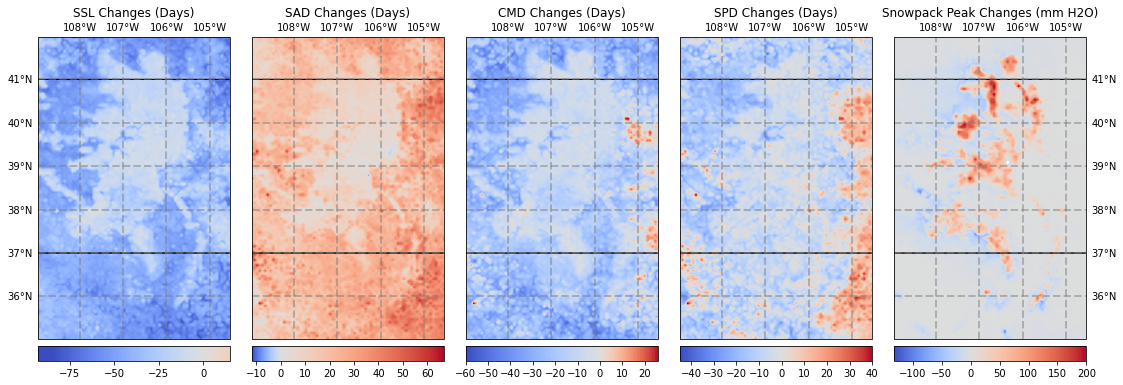

In [53]:
fig = plt.figure(figsize=(15, 7))
# SSL
print('SSL', np.nanmin(CNRM_range_change.data), ' ', np.nanmax(CNRM_range_change.data))
range_norm = colors.Normalize(vmin=-85, vmax=85)
ax = fig.add_subplot(151, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CNRM_range_change, levels=70, norm=range_norm, use_con=True)
ax.set_title('SSL Changes (Days)', fontsize=12)
add_latlon(ax, left=True, bottom=False, right=False, top=True)
# SAD
print('SAD', np.nanmin(CNRM_acc_change.data), ' ', np.nanmax(CNRM_acc_change.data))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-12, vmax=67)
levels1 = np.linspace(-13, 0, 10)
levels2 = np.linspace(0, 68, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(152, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CNRM_acc_change, levels=levels, norm=acc_norm, use_con=False)
ax.set_title('SAD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# CMD
print('CMD', np.nanmin(CNRM_melt_change.data), ' ', np.nanmax(CNRM_melt_change.data))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-60, vmax=26)
levels1 = np.linspace(-61, 0, 60)
levels2 = np.linspace(0, 27, 10)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(153, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CNRM_melt_change, levels=levels, norm=melt_norm, use_con=False)
ax.set_title('CMD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# SPD
print('SPD', np.nanmin(CNRM_date_change.data), ' ', np.nanmax(CNRM_date_change.data))
ax = fig.add_subplot(154, projection=cartopy.crs.PlateCarree())
date_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-45, vmax=40)
levels1 = np.linspace(-46, 0, 50)
levels2 = np.linspace(0, 41, 20)
levels = np.concatenate((levels1[:-1], levels2))
plot_snow(fig, ax, CNRM_date_change, levels=levels, norm=date_norm, use_con=False)
ax.set_title('SPD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# Peak SWE
print('PeakSWE', np.nanmin(CNRM_peak_SWE_change.data), ' ', np.nanmax(CNRM_peak_SWE_change.data))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-133, vmax=200)
levels1 = np.linspace(-134, 0, 70)
levels2 = np.linspace(0, 202, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(155, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, CNRM_peak_SWE_change, levels=levels, norm=peak_SWE_norm, use_con=False)
ax.set_title('Snowpack Peak Changes (mm H2O)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

# GFDL

SSL -78.77777777777777   16.388888888888886
SAD -36.8888888888889   35.111111111111114
CMD -69.5   8.0
SPD -62.33333333333334   19.5
PeakSWE -95.95293676368895   115.86980866889166


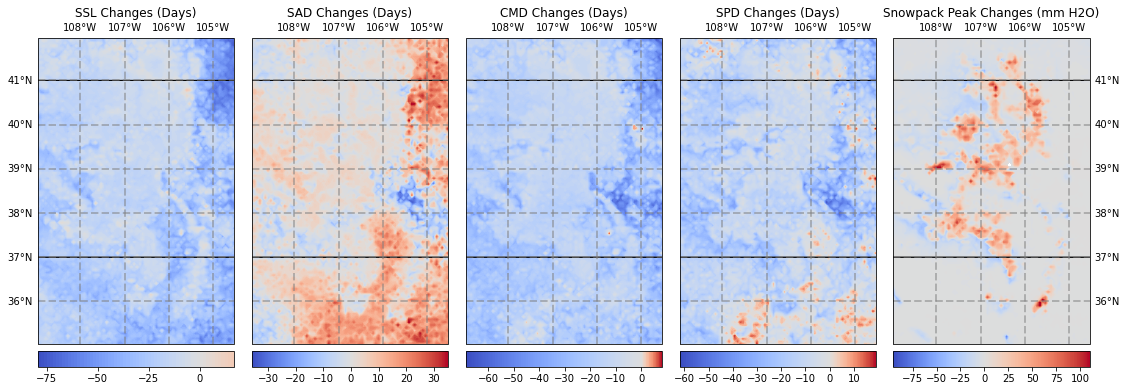

In [55]:
fig = plt.figure(figsize=(15, 7))
# SSL
print('SSL', np.nanmin(GFDL_range_change.data), ' ', np.nanmax(GFDL_range_change.data))
range_norm = colors.Normalize(vmin=-80, vmax=80)
levels = np.linspace(-17, 80, 70)
ax = fig.add_subplot(151, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, GFDL_range_change, levels=70, norm=range_norm, use_con=True)
ax.set_title('SSL Changes (Days)', fontsize=12)
add_latlon(ax, left=True, bottom=False, right=False, top=True)
# SAD
print('SAD', np.nanmin(GFDL_acc_change.data), ' ', np.nanmax(GFDL_acc_change.data))
acc_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-36, vmax=35)
levels1 = np.linspace(-37, 0, 40)
levels2 = np.linspace(0, 36, 40)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(152, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, GFDL_acc_change, levels=levels, norm=acc_norm, use_con=False)
ax.set_title('SAD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# CMD
print('CMD', np.nanmin(GFDL_melt_change.data), ' ', np.nanmax(GFDL_melt_change.data))
melt_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-69, vmax=8)
levels1 = np.linspace(-69, 0, 50)
levels2 = np.linspace(0, 9, 10)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(153, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, GFDL_melt_change, levels=levels, norm=melt_norm, use_con=False)
ax.set_title('CMD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# SPD
print('SPD', np.nanmin(GFDL_date_change.data), ' ', np.nanmax(GFDL_date_change.data))
ax = fig.add_subplot(154, projection=cartopy.crs.PlateCarree())
date_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-62, vmax=19)
levels1 = np.linspace(-63, 0, 55)
levels2 = np.linspace(0, 20, 15)
levels = np.concatenate((levels1[:-1], levels2))
plot_snow(fig, ax, GFDL_date_change, levels=levels, norm=date_norm, use_con=False)
ax.set_title('SPD Changes (Days)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=False, top=True)
# Peak SWE
print('PeakSWE', np.nanmin(GFDL_peak_SWE_change.data), ' ', np.nanmax(GFDL_peak_SWE_change.data))
peak_SWE_norm = colors.TwoSlopeNorm(vcenter=0, vmin=-95, vmax=110)
levels1 = np.linspace(-96, 0, 70)
levels2 = np.linspace(0, 116, 70)
levels = np.concatenate((levels1[:-1], levels2))
ax = fig.add_subplot(155, projection=cartopy.crs.PlateCarree())
plot_snow(fig, ax, GFDL_peak_SWE_change, levels=levels, norm=peak_SWE_norm, use_con=False)
ax.set_title('Snowpack Peak Changes (mm H2O)', fontsize=12)
add_latlon(ax, left=False, bottom=False, right=True, top=True)

plt.tight_layout()
plt.show()

# ALL